Import Libraries

In [ ]:
import pandas as pd
from google.colab import drive
import json

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
json_path = "/content/drive/My Drive/DLProjectDataset/annotation.json"

with open(json_path, 'r') as file:
  data = json.load(file)

In [ ]:
filenames = []
sizes = []
all_points_x = []
all_points_y = []
regions=[]
types = []

for image_id, image_data in data.items():
    filename = image_data['filename']
    size = image_data['size']

    for region in image_data['regions']:
        shape_attr = region['shape_attributes']
        region_attr = region['region_attributes']

        x_points = shape_attr.get('all_points_x', [])
        y_points = shape_attr.get('all_points_y', [])
        leaf_type = region_attr.get('type', 'unknown')

        filenames.append(filename)
        sizes.append(size)
        all_points_x.append(x_points)
        all_points_y.append(y_points)
        types.append(leaf_type)
        regions.append(region)

df = pd.DataFrame({
    'filename': filenames,
    'size': sizes,
    'all_points_x': all_points_x,
    'all_points_y': all_points_y,
    'type': types,
    'regions': regions
})






In [ ]:
df = df.groupby(['filename', 'size']).agg({
        'all_points_x': lambda x: list(x),
        'all_points_y': lambda x: list(x),
        'type': lambda x: list(set(x)),
        'regions': lambda x: list(x)
    }).reset_index()

df.head()

,filename,size,all_points_x,all_points_y,type,regions
0,00387816-9f5f-417f-b71f-1e7e37926db5.jpeg,335027,"[[252, 200, 104, 57, 47, 60, 82, 129, 192, 263...","[[394, 446, 517, 602, 690, 819, 868, 947, 964,...",[camellia],"[{'shape_attributes': {'name': 'polygon', 'all..."
1,00926cdc-6312-40bb-919a-451284dc9bcd.jpeg,425434,"[[512, 471, 474, 523, 575, 611, 613, 586, 537,...","[[1049, 956, 904, 838, 775, 693, 630, 548, 474...",[camellia],"[{'shape_attributes': {'name': 'polygon', 'all..."
2,01302bc6-dfbc-4230-9ff4-53a7f1c11679.jpeg,318053,"[[30, 107, 57, 71, 131, 200, 293, 381, 455, 51...","[[1350, 1287, 1183, 1054, 928, 871, 797, 767, ...",[camellia],"[{'shape_attributes': {'name': 'polygon', 'all..."
3,083cf37c-dbbd-45d8-a823-5a96feec3edf.jpeg,193907,"[[915, 851, 796, 752, 712, 688, 654, 654, 668,...","[[166, 189, 205, 223, 255, 293, 341, 417, 477,...",[river birch],"[{'shape_attributes': {'name': 'polygon', 'all..."
4,0f8b096c-1d29-4542-a7e6-90a2acd97040.jpeg,528275,"[[233, 148, 107, 55, 30, 30, 47, 107, 183, 252...","[[1451, 1394, 1331, 1262, 1155, 1073, 961, 841...",[camellia],"[{'shape_attributes': {'name': 'polygon', 'all..."


In [ ]:
count_csv_path = "/content/drive/My Drive/DLProjectDataset/leafcounts.csv"
leaf_count_df = pd.read_csv(count_csv_path)
leaf_count_df['filename'] = leaf_count_df['filename'] + '.jpeg'

df = pd.merge(df, leaf_count_df, on='filename', how='inner')
df['count']=df['count'].astype(int)

df.head()

,filename,size,all_points_x,all_points_y,type,regions,count
0,00387816-9f5f-417f-b71f-1e7e37926db5.jpeg,335027,"[[252, 200, 104, 57, 47, 60, 82, 129, 192, 263...","[[394, 446, 517, 602, 690, 819, 868, 947, 964,...",[camellia],"[{'shape_attributes': {'name': 'polygon', 'all...",6
1,00926cdc-6312-40bb-919a-451284dc9bcd.jpeg,425434,"[[512, 471, 474, 523, 575, 611, 613, 586, 537,...","[[1049, 956, 904, 838, 775, 693, 630, 548, 474...",[camellia],"[{'shape_attributes': {'name': 'polygon', 'all...",5
2,01302bc6-dfbc-4230-9ff4-53a7f1c11679.jpeg,318053,"[[30, 107, 57, 71, 131, 200, 293, 381, 455, 51...","[[1350, 1287, 1183, 1054, 928, 871, 797, 767, ...",[camellia],"[{'shape_attributes': {'name': 'polygon', 'all...",5
3,083cf37c-dbbd-45d8-a823-5a96feec3edf.jpeg,193907,"[[915, 851, 796, 752, 712, 688, 654, 654, 668,...","[[166, 189, 205, 223, 255, 293, 341, 417, 477,...",[river birch],"[{'shape_attributes': {'name': 'polygon', 'all...",3
4,0f8b096c-1d29-4542-a7e6-90a2acd97040.jpeg,528275,"[[233, 148, 107, 55, 30, 30, 47, 107, 183, 252...","[[1451, 1394, 1331, 1262, 1155, 1073, 961, 841...",[camellia],"[{'shape_attributes': {'name': 'polygon', 'all...",3


In [ ]:
img_dir = "/content/drive/My Drive/DLProjectDataset/images"
save_mask_path = "/content/drive/My Drive/DLProjectDataset/masked_images"

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from ast import literal_eval
from torch.utils.data import Dataset,DataLoader
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from torchvision import transforms


class CustomDataset(Dataset):
    def __init__(self, img_dir, annotations_df, transform=None, mask_transform=None):
        self.img_dir = img_dir
        self.annotations_df = annotations_df
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.annotations_df)

    def __getitem__(self, idx):
        # Load image
        img_name = self.annotations_df.iloc[idx]["filename"]
        img_path = os.path.join(self.img_dir, img_name)
        img = cv2.imread(img_path)

        # Load annotation
        regions = self.annotations_df.iloc[idx]["regions"]
        mask = create_mask_from_annotation(regions, img.shape[:2])

        # Convert to PIL images
        img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert to RGB
        mask = Image.fromarray(mask)

        seed = torch.randint(0, 2**32, (1,)).item()  # Generate a new random seed
        torch.manual_seed(seed)

        # Apply transforms
        if self.transform:
            img = self.transform(img)

        torch.manual_seed(seed)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        mask = np.array(mask)  # Convert mask to NumPy array
        mask = torch.tensor(mask, dtype=torch.long)

        leaf_count = self.annotations_df.iloc[idx]["count"]

        return img, mask, leaf_count

def create_mask_from_annotation(regions, image_size):
    mask = np.zeros(image_size, dtype=np.uint8)  # Background is 0
    for region in regions:
        shape_attributes = region['shape_attributes']
        all_points_x = shape_attributes['all_points_x']
        all_points_y = shape_attributes['all_points_y']

        region_attributes = region['region_attributes']
        class_name = region_attributes['type']
        class_labels = {
            'camellia': 1,
            'river birch': 2,
            'eastern cottonwood': 3,
            'sugar maple': 4
        }

        # Assign class value based on class_name
        if class_name in class_labels:
            color = class_labels[class_name]
        else:
            color = 0  # Default to background if class not found


        # Create polygon and fill the mask
        polygon = list(zip(all_points_x, all_points_y))
        polygon = np.array(polygon, np.int32)
        cv2.fillPoly(mask, [polygon], color)

    return mask



In [ ]:
from torchvision import transforms

# Define separate image and mask transforms
image_transform = transforms.Compose([
  transforms.RandomResizedCrop(size=(224, 224), scale=(0.71, 1.0)),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomVerticalFlip(p=0.5),
   transforms.RandomRotation(degrees=30),
  transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0, hue=0),
  transforms.RandomGrayscale(p=0.2),
  transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
  transforms.ToTensor()
])

mask_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.71, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    # transforms.ToTensor()
])

# Create dataset with separate transforms for images and masks
dataset = CustomDataset(img_dir, df, transform=image_transform, mask_transform=mask_transform)

# Split dataset into train, val, and test
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Compute mean and std on the train set only
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# mean, std = 0., 0.
# for images, masks, counts in train_loader:
#     batch_samples = images.size(0)
#     images = images.view(batch_samples, images.size(1), -1)
#     mean += images.mean(2).sum(0)
#     std += images.std(2).sum(0)
# mean /= len(train_loader.dataset)
# std /= len(train_loader.dataset)



# Add normalization to the transforms for the image
normalize = transforms.Normalize(mean=[0.4829, 0.4384, 0.3892], std=[0.2369, 0.2155, 0.2078])

train_dataset.transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

val_dataset.transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

test_dataset.transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Mask Shape: torch.Size([8, 224, 224])
Image Shape: torch.Size([8, 3, 224, 224])


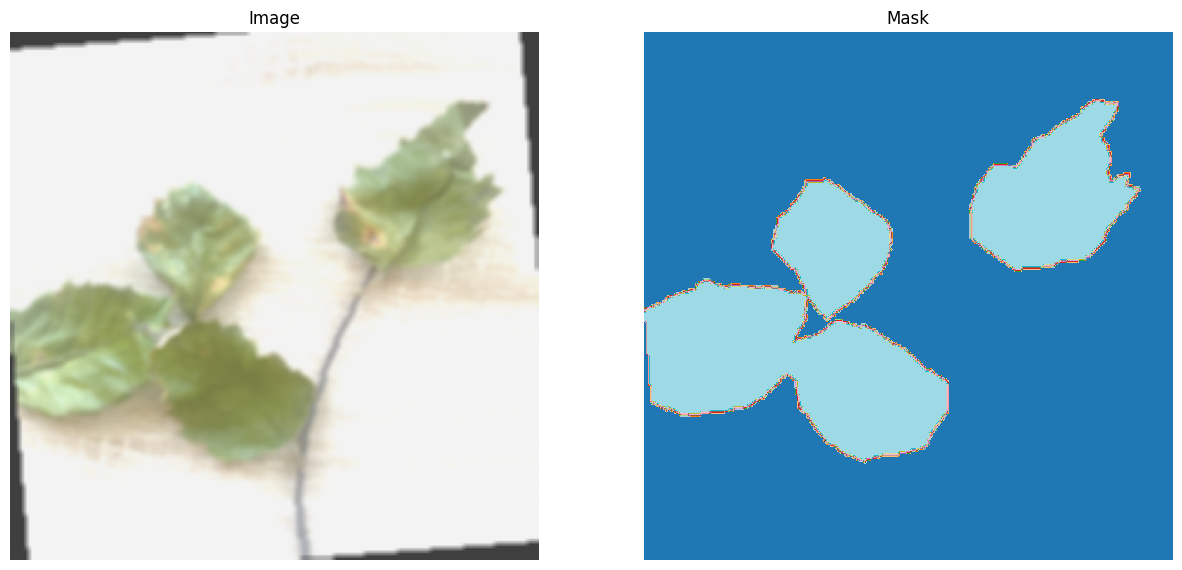

In [ ]:
import matplotlib.pyplot as plt

# Define a function to plot the first sample of each minibatch
def plot_samples(data_loader):
    # Get the first batch
    images, masks, counts = next(iter(data_loader))
    print("Mask Shape:", masks.shape)
    print("Image Shape:", images.shape)

    # Plot image and mask side by side
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))

    # Plot image (revert back to HWC format for proper display)
    ax[0].imshow(images[0].permute(1, 2, 0))  # Convert to HWC format for displaying
    ax[0].set_title("Image")
    ax[0].axis('off')  # Hide axes

    # Plot mask using a colormap to represent the different classes
    # You can use a 'tab20' colormap or define your own colors for classes
    ax[1].imshow(masks[0], cmap='tab20')  # Use tab20 colormap to show different class labels
    ax[1].set_title("Mask")
    ax[1].axis('off')  # Hide axes

    plt.show()

# Call the function to plot samples
plot_samples(train_loader)


**Save mask images back to google drive**

In [ ]:
# if not os.path.exists(save_mask_path):
#       os.makedirs(save_mask_path)
# for idx in range(len(dataset)):
#     # Get the image and its corresponding mask
#     img_name = df.iloc[idx]["filename"]
#     regions = df.iloc[idx]["regions"]

#     # Create mask for the current image
#     img = cv2.imread(os.path.join(img_dir, img_name))
#     mask = create_mask_from_annotation(regions, img.shape[:2])

#     # Save the mask
#     mask_name = img_name.split('.')[0] + "_mask.png"  # Saving mask with _mask suffix
#     mask_path = os.path.join(save_mask_path, mask_name)

#     # Save the mask as a PNG file
#     cv2.imwrite(mask_path, mask)  #
#     print(f"Mask saved for: {img_name}")

In [ ]:
import torch
from torchvision import models
import torch.nn as nn


def convrelu(in_channels, out_channels, kernel, padding):
    """
    Create a sequential layer of 2D convolution followed by ReLU
    """
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


class ResNetUNet(nn.Module):
    """
    The ResNetUNet Class
    """
    def __init__(self, n_class):
        super().__init__()

        self.base_model = models.resnet18(pretrained=False)
        self.base_layers = list(self.base_model.children())

        # size=(N, 64, x.H/2, x.W/2)
        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        # size=(N, 64, x.H/4, x.W/4)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(
            scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)
        self.dropout = nn.Dropout(p=0.25)

    def forward(self, layer_input):
        """
        Perform forward-propagation
        """
        x_original = self.conv_original_size0(layer_input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(layer_input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

class LeafCounter(nn.Module):
    def __init__(self):
        super().__init__()

        # Backbone
        self.counter = models.resnet50()
        for param in self.counter.parameters():
            param.requires_grad = False

        # We will stack the 3 channels of the input image with the mask. Thus, 4 channels in total.
        self.counter.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=2, padding=3, bias=False)
        for param in self.counter.conv1.parameters():
            param.requires_grad = True

        # We will solve regression problem
        self.counter.fc = torch.nn.Linear(2048, 1)
        for param in self.counter.fc.parameters():
            param.requires_grad = True
    def forward(self, x):
        return self.counter(x)

In [ ]:
pretrained_model_path = "/content/drive/My Drive/DLProjectDataset/latest_weights.pth"
state_dict = torch.load(pretrained_model_path, map_location=torch.device('cpu'))
print(len(state_dict))


<ipython-input-13-f42f8ac7bf02>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(pretrained_model_path, map_location=torch.device('cpu'))


268


In [ ]:
state_dict

OrderedDict([('base_model.conv1.weight',
              tensor([[[[ 1.1301e-02,  8.6484e-03,  1.5937e-02,  ...,  2.8274e-02,
                         -7.4327e-03, -5.2435e-03],
                        [-6.7987e-03, -1.1125e-02, -5.2660e-03,  ...,  5.5941e-02,
                         -1.3271e-03, -1.4427e-02],
                        [ 7.1355e-04, -1.4997e-02, -6.6916e-03,  ...,  1.5297e-02,
                         -1.7287e-02,  5.4081e-03],
                        ...,
                        [ 2.7022e-02, -2.8663e-02, -1.4324e-02,  ..., -6.4932e-02,
                         -2.0825e-02, -6.2598e-03],
                        [-2.6297e-03, -8.6352e-03,  1.1741e-02,  ..., -8.8776e-03,
                         -4.0303e-03,  2.3001e-02],
                        [-1.2400e-02, -1.9062e-02,  2.5573e-02,  ..., -2.2049e-02,
                         -6.0880e-03, -2.2507e-02]],
              
                       [[-5.8417e-03,  3.6915e-03,  2.9108e-03,  ...,  1.9330e-02,
                     

In [ ]:
seg_model = ResNetUNet(1)
seg_model.load_state_dict(state_dict)
print(seg_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNetUNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
seg_model.conv_last = nn.Conv2d(64, 5 , kernel_size=(1, 1), stride=(1, 1))
print(seg_model)


ResNetUNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
# Freeze all layers in the model
for param in seg_model.parameters():
    param.requires_grad = False


for param in seg_model.conv_last.parameters():
    param.requires_grad = True

# Check the requires_grad status of all parameters in the model
for name, param in seg_model.named_parameters():
    print(f"Layer: {name}, requires_grad: {param.requires_grad}")


Layer: base_model.conv1.weight, requires_grad: False
Layer: base_model.bn1.weight, requires_grad: False
Layer: base_model.bn1.bias, requires_grad: False
Layer: base_model.layer1.0.conv1.weight, requires_grad: False
Layer: base_model.layer1.0.bn1.weight, requires_grad: False
Layer: base_model.layer1.0.bn1.bias, requires_grad: False
Layer: base_model.layer1.0.conv2.weight, requires_grad: False
Layer: base_model.layer1.0.bn2.weight, requires_grad: False
Layer: base_model.layer1.0.bn2.bias, requires_grad: False
Layer: base_model.layer1.1.conv1.weight, requires_grad: False
Layer: base_model.layer1.1.bn1.weight, requires_grad: False
Layer: base_model.layer1.1.bn1.bias, requires_grad: False
Layer: base_model.layer1.1.conv2.weight, requires_grad: False
Layer: base_model.layer1.1.bn2.weight, requires_grad: False
Layer: base_model.layer1.1.bn2.bias, requires_grad: False
Layer: base_model.layer2.0.conv1.weight, requires_grad: False
Layer: base_model.layer2.0.bn1.weight, requires_grad: False
Layer

In [ ]:
device = torch.device("cuda")
criterion = nn.CrossEntropyLoss()

# counter_criterion = nn.MSELoss()
# Set optimizer to update only the last output layers

seg_model = seg_model.to(device)

In [ ]:
# images, labels, count = next(iter(train_loader))
# output = seg_model(images)
# To print all model weights


In [ ]:
def find_best_lr(model, train_loader, val_loader, criterion, lr_values, num_epochs=20, patience=10):
    best_val_loss = float('inf')
    early_stop_count = 0
    best_lr = None
    train_losses, val_losses = [], []

    for i, lr in enumerate(lr_values):
        optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
        model.train()

        epoch_train_losses, epoch_val_losses = [], []

        for epoch in range(num_epochs):
            train_loss = sum(criterion(model(inputs.to(device)), targets.to(device)).item()
                             for inputs, targets, _ in train_loader)
            model.eval()
            val_loss = sum(criterion(model(inputs.to(device)), targets.to(device)).item()
                           for inputs, targets, _ in val_loader)

            avg_val_loss = val_loss / len(val_loader.dataset)

            epoch_train_losses.append(train_loss / len(train_loader.dataset))
            epoch_val_losses.append(avg_val_loss)

            # Early stopping logic
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                early_stop_count = 0
                best_lr = lr
            else:
                early_stop_count += 1
                if early_stop_count == patience:
                    print(f"Stopping early at LR: {lr:.5f} due to no improvement for {patience} epochs.")
                    break

        train_losses.append(epoch_train_losses)
        val_losses.append(epoch_val_losses)

        print(f"{i+1}/{len(lr_values)}: LR: {lr:.5f}, Train Loss: {epoch_train_losses[-1]:.5f}, Val Loss: {epoch_val_losses[-1]:.5f}")

    return best_lr, val_losses

lr_values = np.logspace(np.log10(1e-6), np.log10(0.1), num=5)
best_lr, val_losses = find_best_lr(seg_model, train_loader, val_loader, criterion, lr_values)
print("Best LR: ", best_lr)


Stopping early at lr: 0.00000 because of no improvement for 10 epochs
 1/5: LR: 0.00000, Train Loss: 0.21365, Val Loss: 0.26407
 2/5: LR: 0.00002, Train Loss: 0.20942, Val Loss: 0.25179
 3/5: LR: 0.00032, Train Loss: 0.12717, Val Loss: 0.15661
 4/5: LR: 0.00562, Train Loss: 0.11650, Val Loss: 0.13954
 5/5: LR: 0.10000, Train Loss: 0.10788, Val Loss: 0.12645
best lr:  0.09999999999999999


In [ ]:
def find_best_momentum(model, train_loader, val_loader, criterion, lr, momentum_values, num_epochs=20, patience=10):
    best_val_loss = float('inf')
    early_stop_count = 0
    best_momentum = None
    train_losses, val_losses = [], []

    for i, momentum in enumerate(momentum_values):
        optimizer = torch.optim.SGD(
            filter(lambda p: p.requires_grad, model.parameters()), lr=lr, momentum=momentum
        )
        model.train()

        epoch_train_losses, epoch_val_losses = [], []

        for epoch in range(num_epochs):
            train_loss = sum(criterion(model(inputs.to(device)), targets.to(device)).item()
                             for inputs, targets, _ in train_loader)

            model.eval()
            val_loss = sum(criterion(model(inputs.to(device)), targets.to(device)).item()
                           for inputs, targets, _ in val_loader)

            avg_val_loss = val_loss / len(val_loader.dataset)

            epoch_train_losses.append(train_loss / len(train_loader.dataset))
            epoch_val_losses.append(avg_val_loss)

            # Early stopping logic
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_momentum = momentum
                early_stop_count = 0
            else:
                early_stop_count += 1
                if early_stop_count == patience:
                    print(f"Stopping early at momentum: {momentum:.5f} due to no improvement for {patience} epochs.")
                    break

        train_losses.append(epoch_train_losses)
        val_losses.append(epoch_val_losses)

        print(f"{i+1}/{len(momentum_values)}: Momentum: {momentum:.5f}, Train Loss: {epoch_train_losses[-1]:.5f}, Val Loss: {epoch_val_losses[-1]:.5f}")

    return best_momentum

momentum_values = [0, 0.5, 0.9, 0.99]
best_mom = find_best_momentum(seg_model, train_loader, val_loader, criterion, best_lr, momentum_values)
print("Best Momentum: ", best_mom)


Stopping early at momentum: 0.00000 because of no improvement for 10 epochs
 1/4: Momentum: 0.00000, Train Loss: 0.10223, Val Loss: 0.11775
Stopping early at momentum: 0.50000 because of no improvement for 10 epochs
 2/4: Momentum: 0.50000, Train Loss: 0.10762, Val Loss: 0.13304
 3/4: Momentum: 0.90000, Train Loss: 0.12124, Val Loss: 0.14599
 4/4: Momentum: 0.99000, Train Loss: 0.58597, Val Loss: 0.86513
best_mom 0.5


In [ ]:
from torch.optim.lr_scheduler import StepLR
optimizer = torch.optim.SGD(
            filter(lambda p: p.requires_grad, seg_model.parameters()), lr=best_lr, momentum=best_mom,  weight_decay=0.001
        )

# Example of using a learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


In [ ]:
from tqdm import tqdm

num_epochs = 20
# Initialize tracking variables
train_losses, valid_losses, test_losses = [], [], []
train_accs, valid_accs, test_accs = [], [], []
best_acc, best_loss = 0, float('inf')
early_stop_counter = 0
patience = 5  # Number of epochs to wait for improvement

# Training loop
for epoch in tqdm(range(num_epochs), desc=f"Training Epochs ({num_epochs})", position=0, leave=True):
    # Train the model
    train_loss, correct_train, total_train = 0, 0, 0
    seg_model.train()
    for inputs, targets, _ in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = seg_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        print("")

        # Compute accuracy
        predicted = torch.argmax(outputs, dim=1)
        print(torch.unique(targets))
        print(torch.unique(predicted))
        correct_pixels = (predicted == targets).sum().item()
        total_pixels = targets.numel()

        correct_train += correct_pixels
        total_train += total_pixels

    train_loss /= len(train_loader.dataset)
    train_acc = 100 * correct_train / total_train

    # Evaluate on validation set
    valid_loss, correct_valid, total_valid = 0, 0, 0
    seg_model.eval()
    with torch.no_grad():
        for inputs, targets, _ in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = seg_model(inputs)
            loss = criterion(outputs, targets)
            valid_loss += loss.item()

            # Compute accuracy
            predicted = torch.argmax(outputs, dim=1)
            correct_pixels = (predicted == targets).sum().item()
            total_pixels = targets.numel()

            correct_valid += correct_pixels
            total_valid += total_pixels
    valid_loss /= len(val_loader.dataset)
    valid_acc = 100 * correct_valid / total_valid

    # Evaluate on test set
    test_loss, correct_test, total_test = 0, 0, 0
    with torch.no_grad():
        for inputs, targets, _ in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = seg_model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            # Compute accuracy
            predicted = torch.argmax(outputs, dim=1)
            correct_pixels = (predicted == targets).sum().item()
            total_pixels = targets.numel()

            correct_test += correct_pixels
            total_test += total_pixels
    test_loss /= len(test_loader.dataset)
    test_acc = 100 * correct_test / total_test

    # Print losses and accuracies
    print(f'\nEpoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.2f}%')
    print(f'Epoch {epoch+1} | Valid Loss: {valid_loss:.4f} | Valid Accuracy: {valid_acc:.2f}%')
    print(f'Epoch {epoch+1} | Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%')

    # Append losses and accuracies to respective lists
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    test_accs.append(test_acc)

    # Save the best model (based on validation loss in this example)
    if valid_loss < best_loss:
        best_loss = valid_loss
        best_model = seg_model.state_dict()
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter == patience:
            print(f'\nEarly stopping after {epoch+1} epochs.')
            break
    scheduler.step()


# Save the best model to file
torch.save(best_model, '/content/drive/My Drive/DLProjectDataset/my_model.pt')


Training Epochs (20):   0%|          | 0/20 [00:00<?, ?it/s]


tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3], device='cuda:0')
tensor([0, 1, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3], device='cuda:0')
tensor([0, 1, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tens

Training Epochs (20):   5%|▌         | 1/20 [01:13<23:25, 73.95s/it]


Epoch 1 | Train Loss: 0.6861 | Train Accuracy: 74.44%
Epoch 1 | Valid Loss: 0.6368 | Valid Accuracy: 67.01%
Epoch 1 | Test Loss: 0.5407 | Test Accuracy: 71.91%

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3], device='cuda:0')


Training Epochs (20):  10%|█         | 2/20 [01:51<15:50, 52.82s/it]


Epoch 2 | Train Loss: 0.4546 | Train Accuracy: 75.03%
Epoch 2 | Valid Loss: 0.2949 | Valid Accuracy: 71.14%
Epoch 2 | Test Loss: 0.3012 | Test Accuracy: 71.34%

tensor([0, 1, 2, 3], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 

Training Epochs (20):  15%|█▌        | 3/20 [02:29<13:02, 46.03s/it]


Epoch 3 | Train Loss: 0.3140 | Train Accuracy: 73.57%
Epoch 3 | Valid Loss: 0.3451 | Valid Accuracy: 70.04%
Epoch 3 | Test Loss: 0.3874 | Test Accuracy: 72.58%

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 

Training Epochs (20):  20%|██        | 4/20 [03:07<11:26, 42.89s/it]


Epoch 4 | Train Loss: 0.2653 | Train Accuracy: 74.45%
Epoch 4 | Valid Loss: 0.2655 | Valid Accuracy: 67.57%
Epoch 4 | Test Loss: 0.2471 | Test Accuracy: 74.87%

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 

Training Epochs (20):  25%|██▌       | 5/20 [03:45<10:16, 41.08s/it]


Epoch 5 | Train Loss: 0.1972 | Train Accuracy: 72.59%
Epoch 5 | Valid Loss: 0.2057 | Valid Accuracy: 70.88%
Epoch 5 | Test Loss: 0.2659 | Test Accuracy: 69.15%

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([

Training Epochs (20):  30%|███       | 6/20 [04:24<09:21, 40.10s/it]


Epoch 6 | Train Loss: 0.1727 | Train Accuracy: 72.77%
Epoch 6 | Valid Loss: 0.2525 | Valid Accuracy: 66.46%
Epoch 6 | Test Loss: 0.2226 | Test Accuracy: 72.81%

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 

Training Epochs (20):  35%|███▌      | 7/20 [05:02<08:32, 39.45s/it]


Epoch 7 | Train Loss: 0.1609 | Train Accuracy: 72.85%
Epoch 7 | Valid Loss: 0.1724 | Valid Accuracy: 69.45%
Epoch 7 | Test Loss: 0.1916 | Test Accuracy: 70.89%

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 

Training Epochs (20):  40%|████      | 8/20 [05:40<07:47, 38.99s/it]


Epoch 8 | Train Loss: 0.1584 | Train Accuracy: 72.02%
Epoch 8 | Valid Loss: 0.1944 | Valid Accuracy: 64.80%
Epoch 8 | Test Loss: 0.2074 | Test Accuracy: 71.22%

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 

Training Epochs (20):  45%|████▌     | 9/20 [06:18<07:05, 38.67s/it]


Epoch 9 | Train Loss: 0.1438 | Train Accuracy: 72.81%
Epoch 9 | Valid Loss: 0.2112 | Valid Accuracy: 68.52%
Epoch 9 | Test Loss: 0.1746 | Test Accuracy: 72.01%

tensor([0, 1, 2, 3], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 

Training Epochs (20):  50%|█████     | 10/20 [06:55<06:23, 38.38s/it]


Epoch 10 | Train Loss: 0.1382 | Train Accuracy: 74.09%
Epoch 10 | Valid Loss: 0.1827 | Valid Accuracy: 71.87%
Epoch 10 | Test Loss: 0.1308 | Test Accuracy: 73.82%

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([

Training Epochs (20):  55%|█████▌    | 11/20 [07:33<05:42, 38.03s/it]


Epoch 11 | Train Loss: 0.1274 | Train Accuracy: 74.86%
Epoch 11 | Valid Loss: 0.1836 | Valid Accuracy: 69.06%
Epoch 11 | Test Loss: 0.1557 | Test Accuracy: 72.10%

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 1, 2, 3, 4], device='cuda:0')
tensor([0, 1, 2, 3, 4], device='cuda:0')

tensor([0, 

Training Epochs (20):  55%|█████▌    | 11/20 [08:10<06:41, 44.61s/it]


Epoch 12 | Train Loss: 0.1259 | Train Accuracy: 74.85%
Epoch 12 | Valid Loss: 0.1952 | Valid Accuracy: 68.49%
Epoch 12 | Test Loss: 0.1499 | Test Accuracy: 74.30%

Early stopping after 12 epochs.


In [ ]:
torch.save(best_model, '/content/drive/My Drive/DLProjectDataset/segmentation_model.pt')

In [ ]:
print("train_losses:",train_losses)
print("validation losses: ", valid_losses)
print("test losses: ", test_losses)
print("train_accs: ", train_accs)
print("valid_accs: ", valid_accs)
print("test_accs: ", test_accs)

train_losses: [0.6861166939045649, 0.45457833667971054, 0.3139537640337674, 0.26531402644871166, 0.19722830424518706, 0.17272867609120016, 0.16093117973339632, 0.15837170118056004, 0.1437890278468342, 0.13820090871187127, 0.12737552324930826, 0.12589695206228294]
validation losses:  [0.6367956588142797, 0.2949247548454686, 0.3450957787664313, 0.2655120335127178, 0.20565606418408847, 0.25253256371146754, 0.17242594141709178, 0.19435152882023862, 0.2111614566100271, 0.1826564167675219, 0.18364441081097252, 0.19518853802430003]
test losses:  [0.5406968934195382, 0.3011602787744431, 0.3874045723960513, 0.24707849820454916, 0.2658772355034238, 0.2226283379963466, 0.19163452443622409, 0.20742850644247873, 0.1745895885285877, 0.13077083371934436, 0.15565492993309385, 0.14986073686963036]
train_accs:  [74.43634883198563, 75.03032094323578, 73.56506355490309, 74.45226764054678, 72.58831303747914, 72.76971224810679, 72.8488926525799, 72.01544901569119, 72.8119785650109, 74.0886795461109, 74.8627

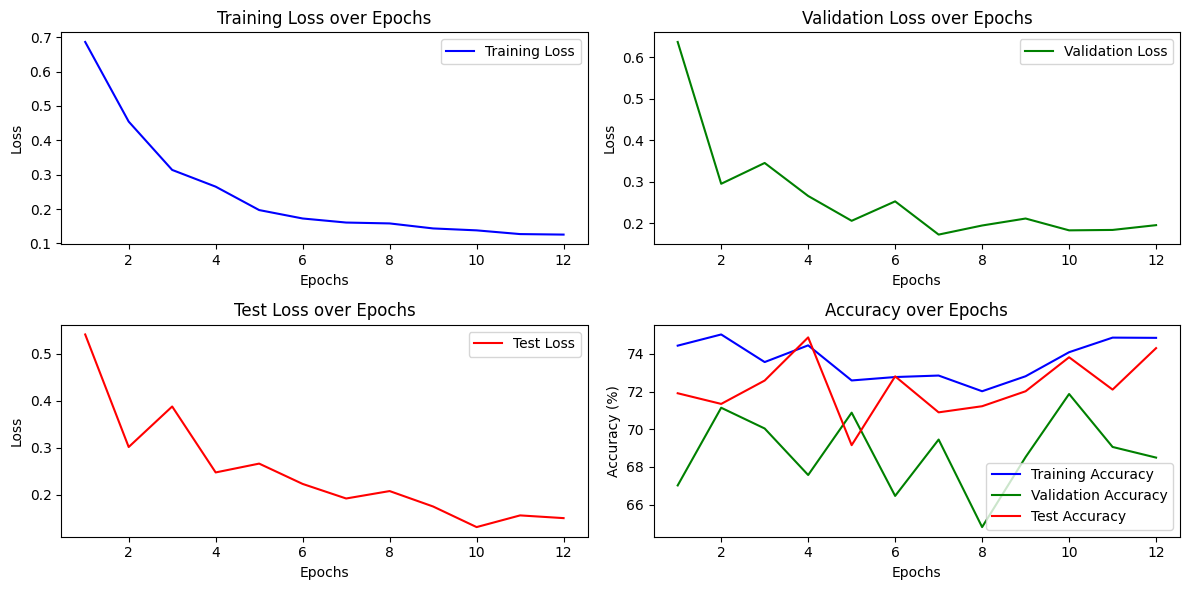

In [ ]:
import matplotlib.pyplot as plt

# Plotting the losses over epochs
plt.figure(figsize=(12, 6))

# Training loss
plt.subplot(2, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Validation loss
plt.subplot(2, 2, 2)
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()

# Test loss
plt.subplot(2, 2, 3)
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Loss over Epochs')
plt.legend()

# Plotting the accuracies over epochs
plt.subplot(2, 2, 4)
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Training Accuracy', color='blue')
plt.plot(range(1, len(valid_accs) + 1), valid_accs, label='Validation Accuracy', color='green')
plt.plot(range(1, len(test_accs) + 1), test_accs, label='Test Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


s**Evaluation in test dataset**

In [ ]:
def calculate_iou(pred_mask, true_mask, num_classes):
    ious = []
    for cls in range(num_classes):  # Iterate over each class
        # Create binary masks for the class
        pred_binary = (pred_mask == cls).float()
        true_binary = (true_mask == cls).float()

        # Calculate intersection and union
        intersection = (pred_binary * true_binary).sum()
        union = pred_binary.sum() + true_binary.sum() - intersection

        # Avoid division by zero
        if union == 0:
            iou = float('nan')  # Class not present in either ground truth or prediction
        else:
            iou = intersection / union
        ious.append(iou.item())
    return ious


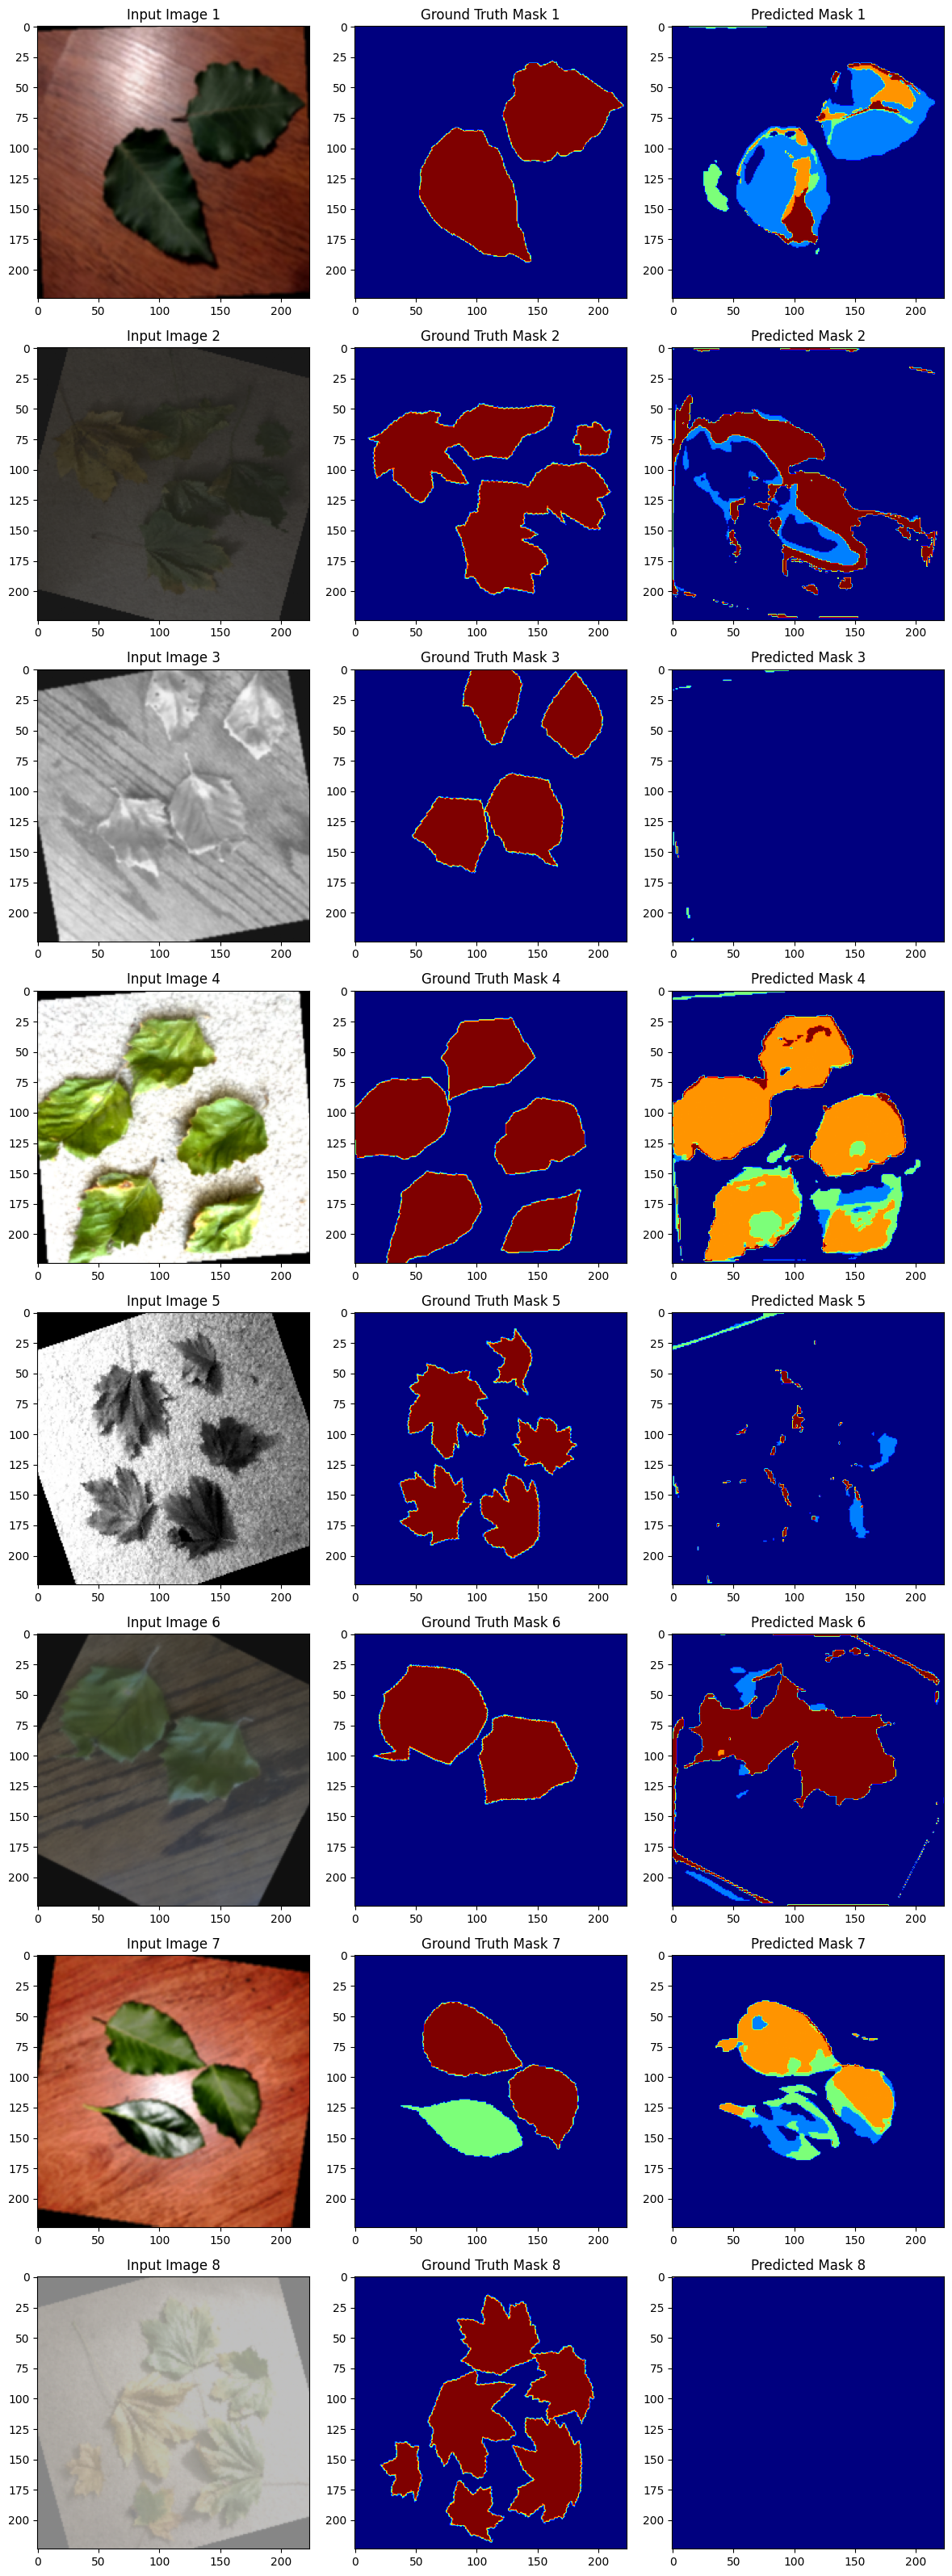

In [ ]:
seg_model.eval()
import matplotlib.pyplot as plt
import torch

# Load a batch from the test set
inputs, targets, _ = next(iter(test_loader))
inputs, targets, _ = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)

# Get model outputs
with torch.no_grad():
    outputs = seg_model(inputs)

# Convert logits to class predictions
predicted = torch.argmax(outputs, dim=1)

# Determine the number of images in the batch (assuming batch size is 4 for example)
batch_size = inputs.size(0)
num_classes = outputs.size(1)

iou_scores = []
# Plot the entire batch of images
plt.figure(figsize=(12, batch_size * 4))

for i in range(batch_size):
    iou = calculate_iou(predicted[i].cpu(), targets[i].cpu(), num_classes)
    iou_scores.append(iou)
    # Plot input image
    plt.subplot(batch_size, 3, 3 * i + 1)
    plt.imshow(inputs[i].cpu().numpy().transpose(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    plt.title(f'Input Image {i+1}')

    # Plot ground truth mask
    plt.subplot(batch_size, 3, 3 * i + 2)
    plt.imshow(targets[i].cpu().numpy(), cmap='jet')
    plt.title(f'Ground Truth Mask {i+1}')

    # Plot predicted mask
    plt.subplot(batch_size, 3, 3 * i + 3)
    plt.imshow(predicted[i].cpu().numpy(), cmap='jet')
    plt.title(f'Predicted Mask {i+1}')

plt.tight_layout()
plt.show()



In [ ]:
print("IoU scores for each image:")
for i, ious in enumerate(iou_scores):
    avg_iou = np.nanmean(ious)  # Average IoU, ignoring NaN
    print(f"Image {i+1} Average IoU = {avg_iou:.4f}")

IoU scores for each image:
Image 1 Average IoU = 0.1931
Image 2 Average IoU = 0.1984
Image 3 Average IoU = 0.1581
Image 4 Average IoU = 0.3467
Image 5 Average IoU = 0.1646
Image 6 Average IoU = 0.1803
Image 7 Average IoU = 0.2795
Image 8 Average IoU = 0.1404


**Leaf Counter Model**

In [ ]:
counter_model = LeafCounter().to(device)
print(counter_model)

LeafCounter(
  (counter): ResNet(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [ ]:
images, masks, leaf_counts = next(iter(train_loader))
images, masks, leaf_counts = images.to(device), masks.to(device), leaf_counts.to(device)
masks = masks.float().unsqueeze(1).to(device)  # Ensure masks have 1 channel

# Concatenate images (3 channels) with masks (1 channel) along the channel dimension (dim=1)
inputs = torch.cat((images, masks), dim=1)
print(inputs.shape)  # Check the shape, should be [batch_size, 4, height, width]

# Pass the concatenated tensor as input to the model
output = counter_model(inputs).squeeze()
print(output)



torch.Size([8, 4, 224, 224])
tensor([ 0.0284, -0.0037, -0.0059,  0.2823, -0.0040,  0.0556,  0.0705,  0.1293],
       device='cuda:0', grad_fn=<SqueezeBackward0>)


In [ ]:
# Define the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeafCounter().to(device)
criterion = nn.MSELoss()  # Regression loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Training and validation loop
num_epochs = 20
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    train_mae = 0

    for images, masks, leaf_counts in train_loader:
        # Prepare inputs
        images = images.float().to(device)
        masks = masks.float().unsqueeze(1).to(device)
        inputs = torch.cat((images, masks), dim=1)
        leaf_counts = leaf_counts.float().to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        print(outputs)
        loss = criterion(outputs, leaf_counts)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_mae += torch.abs(outputs - leaf_counts).mean().item()  # Accumulate MAE

    # Average train metrics
    train_loss /= len(train_loader)
    train_mae /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    val_mae = 0

    with torch.no_grad():
        for images, masks, leaf_counts in val_loader:
            images = images.float().to(device)
            masks = masks.float().unsqueeze(1).to(device)
            inputs = torch.cat((images, masks), dim=1)
            leaf_counts = leaf_counts.float().to(device)

            outputs = model(inputs).squeeze()
            loss = criterion(outputs, leaf_counts)

            val_loss += loss.item()
            val_mae += torch.abs(outputs - leaf_counts).mean().item()  # Accumulate MAE

    # Average validation metrics
    val_loss /= len(val_loader)
    val_mae /= len(val_loader)

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}")


tensor([-0.8485, -0.5848, -0.5517, -0.6120, -0.5977, -0.5511, -0.6628, -0.6562],
       device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor([10.3241,  6.5017,  7.6784,  9.2359,  7.5432,  5.9951,  8.4025, 16.0484],
       device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor([ 5.4135,  7.0386,  5.9023,  5.3910,  7.2825,  6.1773, 17.3779, 12.6792],
       device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor([3.8292, 3.5554, 4.8687, 3.3344, 3.3679, 8.2963, 3.5136, 6.3247],
       device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor([0.3146, 0.9969, 1.1045, 0.8788, 0.8550, 0.7355, 0.9399, 1.0052],
       device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor([ 0.5068,  0.2473,  0.4381,  0.5059, -1.5761,  0.5590,  0.6829,  0.0467],
       device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor([1.4192, 1.5939, 1.0539, 1.5229, 1.5047, 1.4190, 1.6116, 1.2993],
       device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor([3.1531, 3.1890, 3.1826, 3.1490, 3.2830, 3.9844, 3.8420, 3.1894],
       device='cuda:

In [ ]:
torch.save(model, '/content/drive/My Drive/DLProjectDataset/counter_model.pt')

In [ ]:
# Test loop
model.eval()  # Set the model to evaluation mode
test_loss = 0
test_mae = 0

# Initialize lists to store predicted and actual leaf counts for comparison
predicted_counts = []
actual_counts = []

with torch.no_grad():  # No need to compute gradients during inference
    for images, masks, leaf_counts in val_loader:
        # Prepare inputs
        images = images.float().to(device)
        masks = masks.float().unsqueeze(1).to(device)
        inputs = torch.cat((images, masks), dim=1)
        leaf_counts = leaf_counts.float().to(device)

        # Get predictions
        outputs = model(inputs).squeeze()

        # Calculate loss and MAE
        loss = criterion(outputs, leaf_counts)
        test_loss += loss.item()
        test_mae += torch.abs(outputs - leaf_counts).mean().item()

        # Store predicted and actual values for further comparison
        predicted_counts.extend(outputs.cpu().numpy())  # Move predictions to CPU and store as a list
        actual_counts.extend(leaf_counts.cpu().numpy())  # Same for actual leaf counts

        # Print predictions and ground truth for each sample in the batch
        for pred, actual in zip(outputs, leaf_counts):
          print(f"Predicted Count (Test): {round(pred.item())}, Actual Count (Test): {round(actual.item())}")

# Calculate average test metrics
test_loss /= len(test_loader)
test_mae /= len(test_loader)

# Print test results
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")




Predicted Count (Test): 5, Actual Count (Test): 6
Predicted Count (Test): 5, Actual Count (Test): 6
Predicted Count (Test): 6, Actual Count (Test): 8
Predicted Count (Test): 5, Actual Count (Test): 3
Predicted Count (Test): 6, Actual Count (Test): 6
Predicted Count (Test): 6, Actual Count (Test): 6
Predicted Count (Test): 5, Actual Count (Test): 4
Predicted Count (Test): 5, Actual Count (Test): 2
Predicted Count (Test): 6, Actual Count (Test): 3
Predicted Count (Test): 5, Actual Count (Test): 4
Predicted Count (Test): 5, Actual Count (Test): 3
Predicted Count (Test): 5, Actual Count (Test): 4
Predicted Count (Test): 5, Actual Count (Test): 5
Predicted Count (Test): 5, Actual Count (Test): 1
Predicted Count (Test): 6, Actual Count (Test): 3
Predicted Count (Test): 5, Actual Count (Test): 8
Predicted Count (Test): 6, Actual Count (Test): 1
Predicted Count (Test): 5, Actual Count (Test): 1
Predicted Count (Test): 5, Actual Count (Test): 6
Test Loss: 7.9029, Test MAE: 2.2883


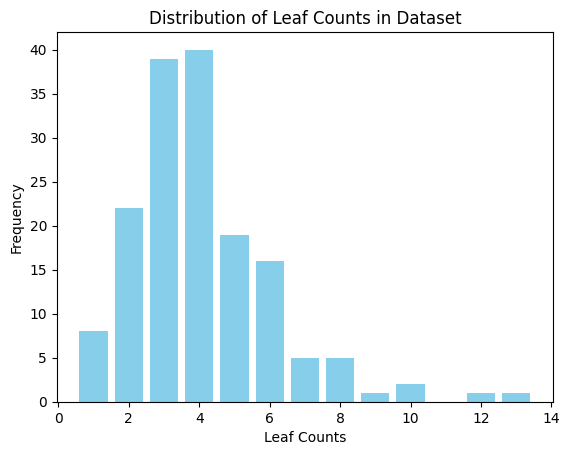

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Assuming train_loader.dataset contains the dataset
leaf_counts_all = [leaf_counts.item() for _, _, leaf_counts in train_loader.dataset]

# Count occurrences of each leaf count
count_distribution = Counter(leaf_counts_all)

# Sort by leaf count
sorted_counts = sorted(count_distribution.items())  # [(count1, freq1), (count2, freq2), ...]
counts, frequencies = zip(*sorted_counts)

# Plot the distribution
plt.bar(counts, frequencies, color='skyblue')
plt.xlabel('Leaf Counts')
plt.ylabel('Frequency')
plt.title('Distribution of Leaf Counts in Dataset')
plt.show()
